In [2]:
from gorillatracker.utils.embedding_generator import generate_embeddings_from_run, read_embeddings_from_disk
import numpy as np

regen = False

examples = [
    (
        "https://wandb.ai/gorillas/Embedding-SwinV2Large-CXL-Open/runs/bp5e1rnx/workspace?nw=nwuserliamvdv",
        "../swin-large-example-embeddings.pkl",
        {
            "dataset_cls": "gorillatracker.datasets.cxl.CXLDataset",
            "data_dir": "/workspaces/gorillatracker/data/splits/ground_truth-cxl-face_images-openset-reid-val-0-test-0-mintraincount-3-seed-42-train-50-val-25-test-25",
        },
    ),
    (
        "https://wandb.ai/gorillas/Embedding-SwinV2Large-CXL-Open/runs/bp5e1rnx/workspace?nw=nwuserliamvdv",
        "../bristol_embeddings-cxl_trained.pkl",
        {
            "dataset_cls": "gorillatracker.datasets.bristol.BristolDataset",
            "data_dir": "/workspaces/gorillatracker/data/splits/ground_truth-bristol-cropped_images_face-closedset-mintraincount-3-seed-42-train-0-val-100-test-0",
        },
    ),
]
current = 1

if regen:
    df = generate_embeddings_from_run(examples[current][0], examples[current][1], **examples[current][2])
else:
    # df = read_embeddings_from_disk("../example-embeddings.pkl")
    df = read_embeddings_from_disk(examples[current][1])

df["embedding"] = df["embedding"].apply(lambda x: np.array(x))
df.head()

,index,embedding,label,input,label_string,partition,id
0,0,"[0.9752537, -0.44755855, -0.29229507, 0.569760...",0,<PIL.Image.Image image mode=RGB size=192x192 a...,kera,val,/workspaces/gorillatracker/data/splits/ground_...
1,0,"[0.08688405, 0.10634421, -0.05147969, 0.343416...",0,<PIL.Image.Image image mode=RGB size=192x192 a...,kera,val,/workspaces/gorillatracker/data/splits/ground_...
2,0,"[-0.045863245, -1.0779585, 0.52481455, 0.32094...",1,<PIL.Image.Image image mode=RGB size=192x192 a...,touni,val,/workspaces/gorillatracker/data/splits/ground_...
3,0,"[-0.27572802, 0.61718154, -0.568022, 0.6098473...",0,<PIL.Image.Image image mode=RGB size=192x192 a...,kera,val,/workspaces/gorillatracker/data/splits/ground_...
4,0,"[-0.059182808, 0.6869696, 1.2142066, 1.097649,...",0,<PIL.Image.Image image mode=RGB size=192x192 a...,kera,val,/workspaces/gorillatracker/data/splits/ground_...


In [3]:
df["label"].value_counts()

label
3    1006
1     955
0     954
2     794
4     745
5     642
6     498
Name: count, dtype: int64

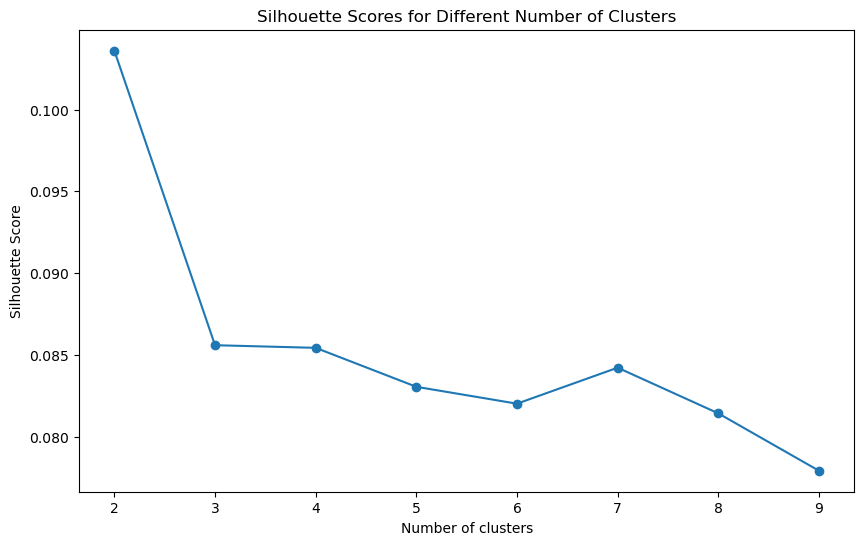

Optimal number of classes: 2


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    DBSCAN,
    MeanShift,
    SpectralClustering,
    AffinityPropagation,
    OPTICS,
    Birch,
)
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Extract embeddings and labels
embeddings = np.vstack(df["embedding"].values)
labels = df["label"].values

# Finding the optimal number of clusters using silhouette score
silhouette_scores = []
k_range = range(2, 10)  # Example range of clusters to test

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker="o")
plt.title("Silhouette Scores for Different Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Find the number of classes based on the highest silhouette score
optimal_clusters = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of classes: {optimal_clusters}")

In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


def compute_metrics(embeddings, labels):
    metrics = {}
    if len(set(labels)) > 1:
        metrics["silhouette_score"] = silhouette_score(embeddings, labels)
        metrics["davies_bouldin_score"] = davies_bouldin_score(embeddings, labels)
        metrics["calinski_harabasz_score"] = calinski_harabasz_score(embeddings, labels)

        # Compute Within-cluster Sum of Squares (WCSS)
        wcss = 0
        for label in np.unique(labels):
            cluster_points = embeddings[labels == label]
            centroid = cluster_points.mean(axis=0)
            wcss += ((cluster_points - centroid) ** 2).sum()
        metrics["wcss"] = wcss

        # Compute Average Intra-cluster Distance
        intra_distances = []
        for label in np.unique(labels):
            cluster_points = embeddings[labels == label]
            centroid = cluster_points.mean(axis=0)
            intra_distances.extend(np.linalg.norm(cluster_points - centroid, axis=1))
        metrics["average_intra_distance"] = np.mean(intra_distances)

        # Compute Dunn Index (simplified version)
        # Finding maximum intra-cluster distance and minimum inter-cluster distance
        max_intra_dist = max(intra_distances)
        min_inter_dist = np.inf
        for i in np.unique(labels):
            for j in np.unique(labels):
                if i != j:
                    cluster_i = embeddings[labels == i]
                    cluster_j = embeddings[labels == j]
                    dists = np.linalg.norm(cluster_i[:, np.newaxis] - cluster_j, axis=2)
                    min_inter_dist = min(min_inter_dist, np.min(dists))
        metrics["dunn_index"] = min_inter_dist / max_intra_dist if max_intra_dist != 0 else 0
    else:
        metrics = {
            metric: -1
            for metric in [
                "silhouette_score",
                "davies_bouldin_score",
                "calinski_harabasz_score",
                "wcss",
                "average_intra_distance",
                "dunn_index",
            ]
        }

    return metrics


def kmeans_clustering(embeddings):
    results = []
    for k in range(2, 10):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(embeddings)
        metrics = compute_metrics(embeddings, labels)
        results.append({"clusters": k, **metrics})
    return results


def agglomerative_clustering(embeddings):
    results = []
    for k in range(2, 10):
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(embeddings)
        metrics = compute_metrics(embeddings, labels)
        results.append({"clusters": k, **metrics})
    return results


def dbscan_clustering(embeddings):
    model = DBSCAN(eps=0.5, min_samples=2)
    labels = model.fit_predict(embeddings)
    metrics = compute_metrics(embeddings, labels)
    return [{"clusters": len(set(labels)) - (1 if -1 in labels else 0), **metrics}]


def spectral_clustering(embeddings):
    results = []
    for k in range(2, 10):
        model = SpectralClustering(n_clusters=k, assign_labels="discretize", random_state=42)
        labels = model.fit_predict(embeddings)
        metrics = compute_metrics(embeddings, labels)
        results.append({"clusters": k, **metrics})
    return results


def gaussian_mixture_clustering(embeddings):
    """
    Gives likelihood of each sample belonging to each cluster.
    Computed using the Expectation-Maximization algorithm, which is a generalization of the KMeans algorithm.
        GMM uses the EM algorithm to estimate the parameters of the Gaussian components. The algorithm alternates between:
            Expectation Step: Calculating the probability that each data point belongs to each Gaussian component.
            Maximization Step: Updating the parameters (means, variances, and weights) of the Gaussian components to maximize the likelihood of the data given the current assignments.
    Assumes data is generated from a mixture of Gaussian distributions, each with own mean, covariance, and a weight in the total distribution.
    """
    results = []
    for k in range(2, 10):
        model = GaussianMixture(n_components=k, random_state=42)
        labels = model.fit_predict(embeddings)
        metrics = compute_metrics(embeddings, labels)
        results.append({"clusters": k, **metrics})
    return results


def mean_shift_clustering(embeddings):
    model = MeanShift()
    labels = model.fit_predict(embeddings)
    metrics = compute_metrics(embeddings, labels)
    return [{"clusters": len(set(labels)), **metrics}]


def birch_clustering(embeddings):
    results = []
    for k in range(2, 10):
        model = Birch(n_clusters=k)
        labels = model.fit_predict(embeddings)
        metrics = compute_metrics(embeddings, labels)
        results.append({"clusters": k, **metrics})
    return results


def affinity_propagation_clustering(embeddings):
    model = AffinityPropagation(random_state=42)
    labels = model.fit_predict(embeddings)
    metrics = compute_metrics(embeddings, labels)
    return [{"clusters": len(set(labels)), **metrics}]


def optics_clustering(embeddings):
    model = OPTICS(min_samples=2)
    labels = model.fit_predict(embeddings)
    metrics = compute_metrics(embeddings, labels)
    return [{"clusters": len(set(labels)) - (1 if -1 in labels else 0), **metrics}]


# Example usage
clustering_results = {}

# Perform clustering and store results
# Takes ~10 minutes to run
print("Computing clustering results...")
print("KMeans")
clustering_results["KMeans"] = kmeans_clustering(embeddings)
print("Agglomerative")
clustering_results["Agglomerative"] = agglomerative_clustering(embeddings)
print("DBSCAN")
clustering_results["DBSCAN"] = dbscan_clustering(embeddings)
# print("Spectral")
# clustering_results["Spectral"] = spectral_clustering(embeddings)
print("GaussianMixture")
clustering_results["GaussianMixture"] = gaussian_mixture_clustering(embeddings)
print("MeanShift")
clustering_results["MeanShift"] = mean_shift_clustering(embeddings)
print("BIRCH")
clustering_results["BIRCH"] = birch_clustering(embeddings)
print("AffinityPropagation")
clustering_results["AffinityPropagation"] = affinity_propagation_clustering(embeddings)
print("OPTICS")
clustering_results["OPTICS"] = optics_clustering(embeddings)

Computing clustering results...
KMeans
Agglomerative
DBSCAN
GaussianMixture
MeanShift
BIRCH
AffinityPropagation


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


OPTICS


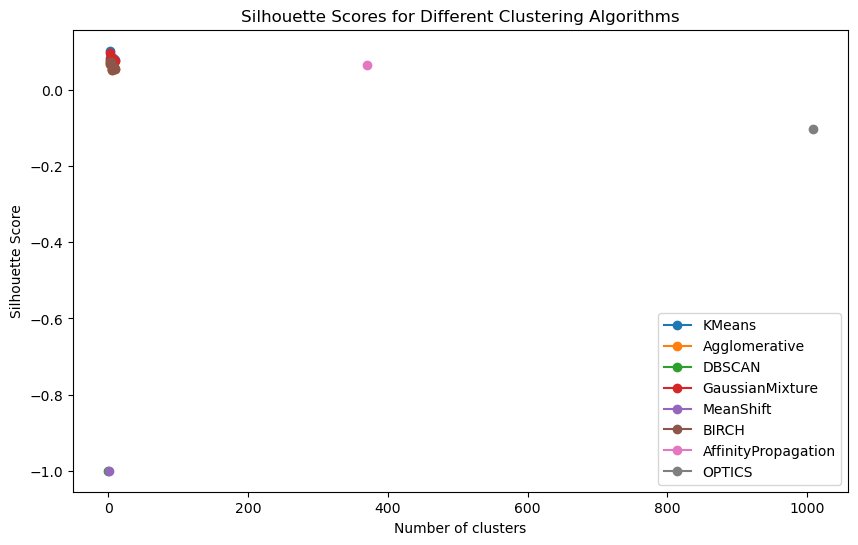

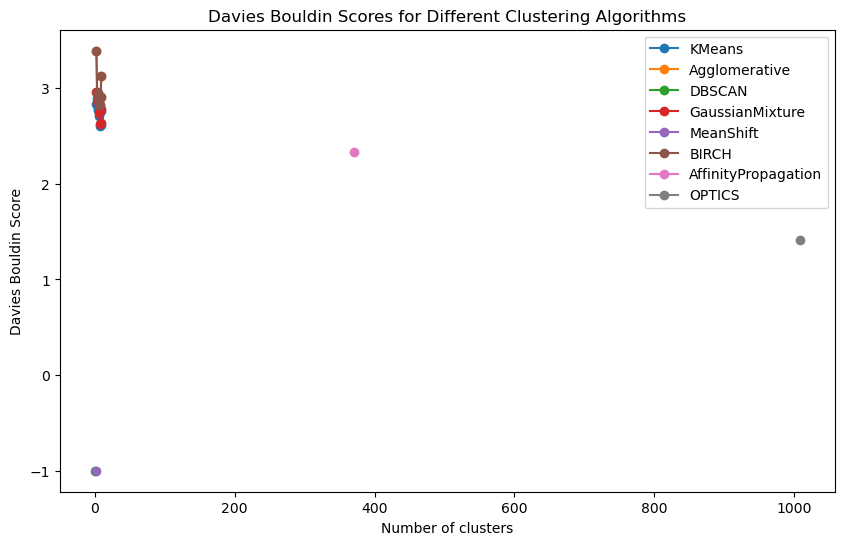

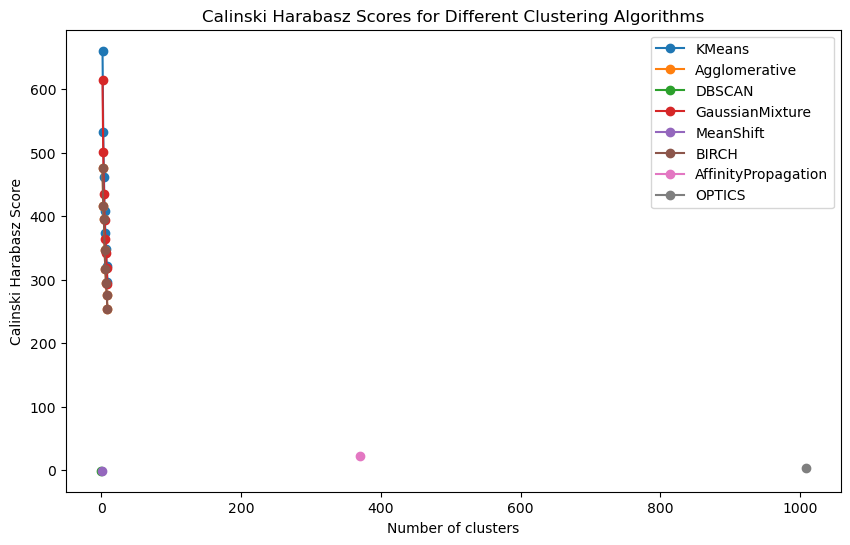

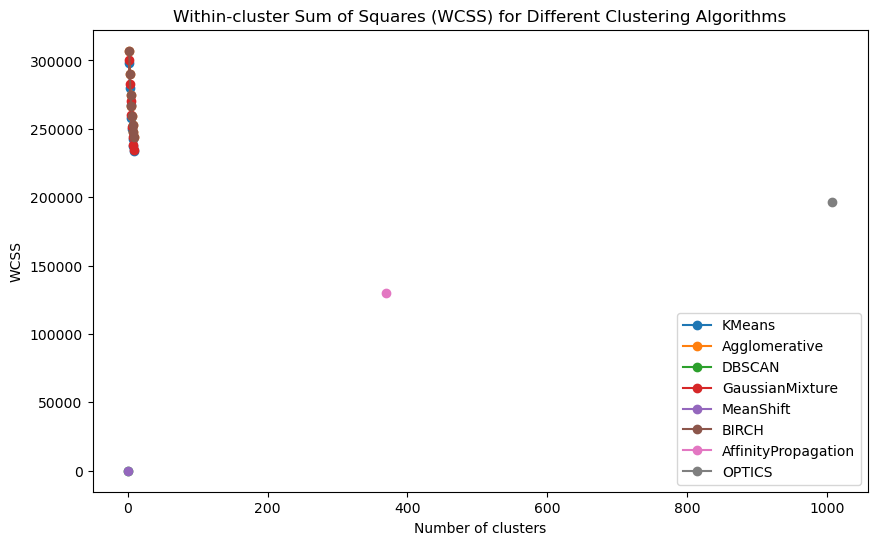

In [12]:
def plot_clustering_results(clustering_results, metric="silhouette_score"):
    # plot silhouette scores for different clustering algorithms
    plt.figure(figsize=(10, 6))
    for model, results in clustering_results.items():
        clusters = [result["clusters"] for result in results]
        silhouette_scores = [result["silhouette_score"] for result in results]
        plt.plot(clusters, silhouette_scores, marker="o", label=model)
    plt.title("Silhouette Scores for Different Clustering Algorithms")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.show()

    # plot davies_bouldin_score for different clustering algorithms
    plt.figure(figsize=(10, 6))
    for model, results in clustering_results.items():
        clusters = [result["clusters"] for result in results]
        davies_bouldin_scores = [result["davies_bouldin_score"] for result in results]
        plt.plot(clusters, davies_bouldin_scores, marker="o", label=model)
    plt.title("Davies Bouldin Scores for Different Clustering Algorithms")
    plt.xlabel("Number of clusters")
    plt.ylabel("Davies Bouldin Score")
    plt.legend()
    plt.show()

    # plot calinski_harabasz_score for different clustering algorithms
    plt.figure(figsize=(10, 6))
    for model, results in clustering_results.items():
        clusters = [result["clusters"] for result in results]
        calinski_harabasz_scores = [result["calinski_harabasz_score"] for result in results]
        plt.plot(clusters, calinski_harabasz_scores, marker="o", label=model)
    plt.title("Calinski Harabasz Scores for Different Clustering Algorithms")
    plt.xlabel("Number of clusters")
    plt.ylabel("Calinski Harabasz Score")
    plt.legend()
    plt.show()

    # plot wcss for different clustering algorithms
    plt.figure(figsize=(10, 6))
    for model, results in clustering_results.items():
        clusters = [result["clusters"] for result in results]
        wcss = [result["wcss"] for result in results]
        plt.plot(clusters, wcss, marker="o", label=model)

    plt.title("Within-cluster Sum of Squares (WCSS) for Different Clustering Algorithms")
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    plt.legend()
    plt.show()


plot_clustering_results(clustering_results)

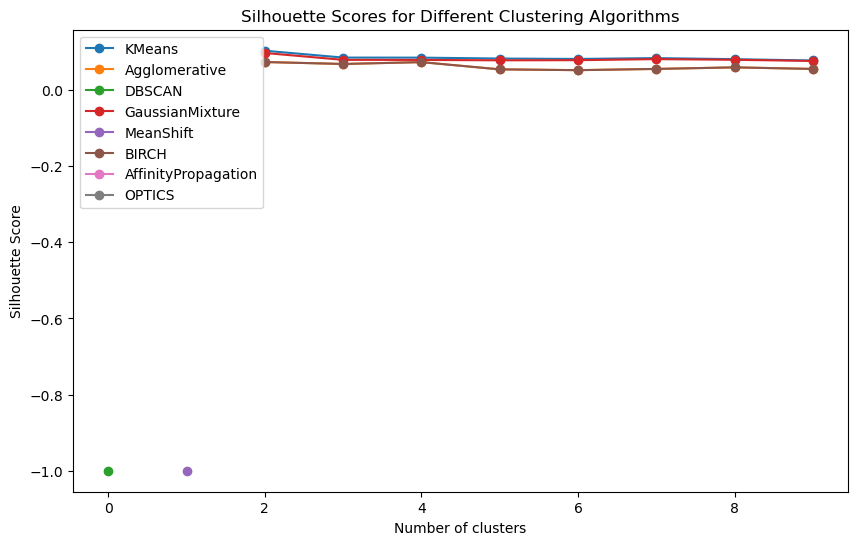

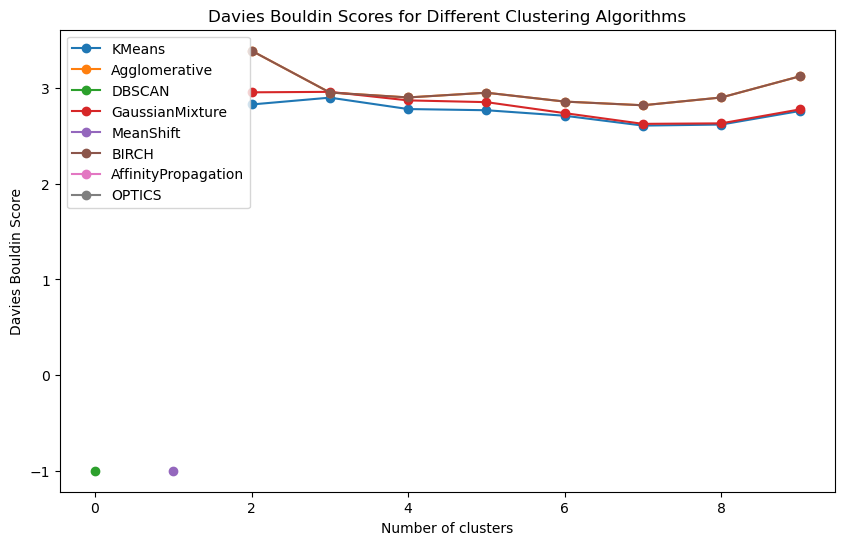

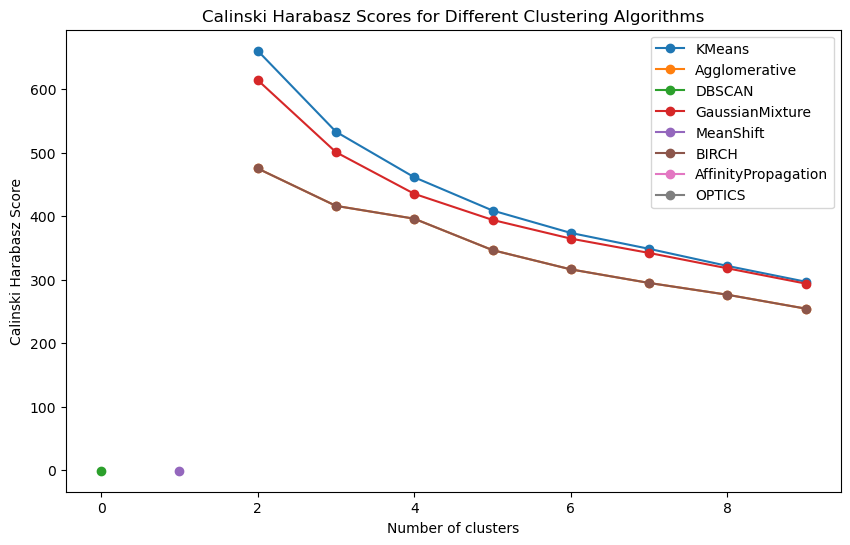

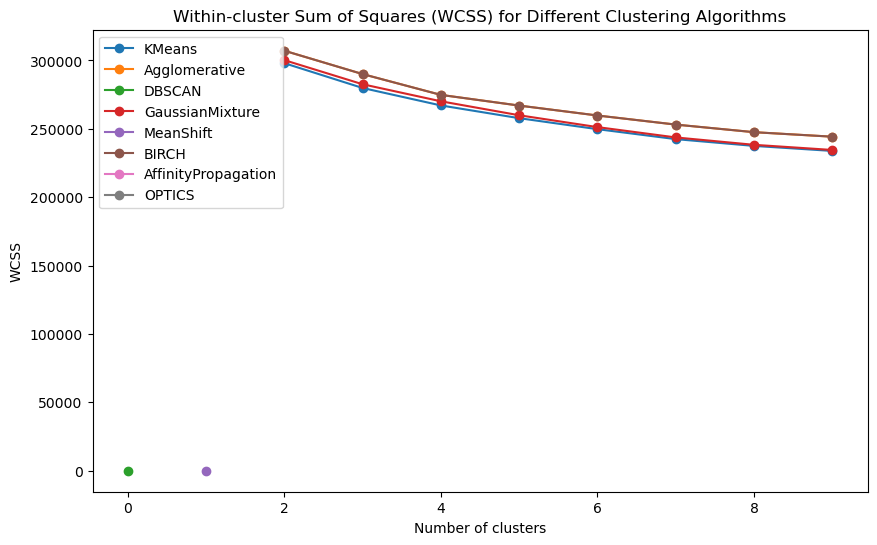

In [14]:
# filter n_clusters > 10
clustering_results_filtered = {
    model: [result for result in results if result["clusters"] <= 10] for model, results in clustering_results.items()
}
plot_clustering_results(clustering_results_filtered)

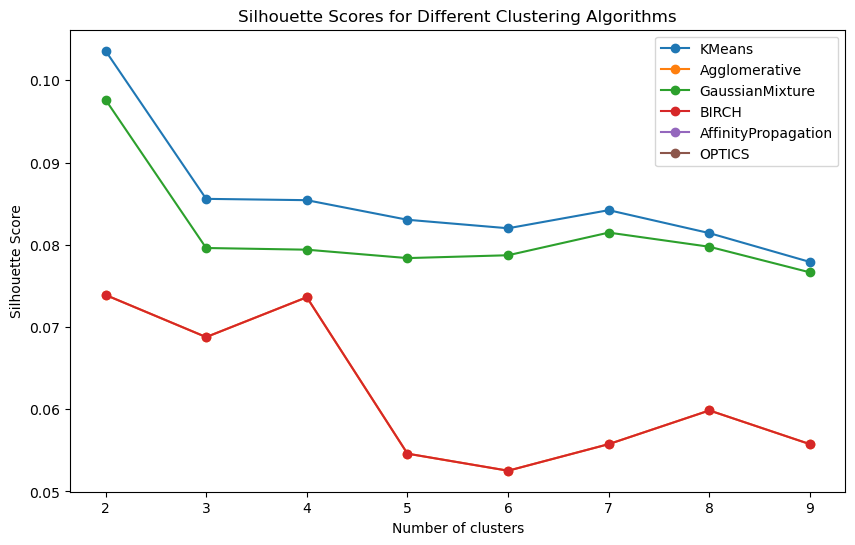

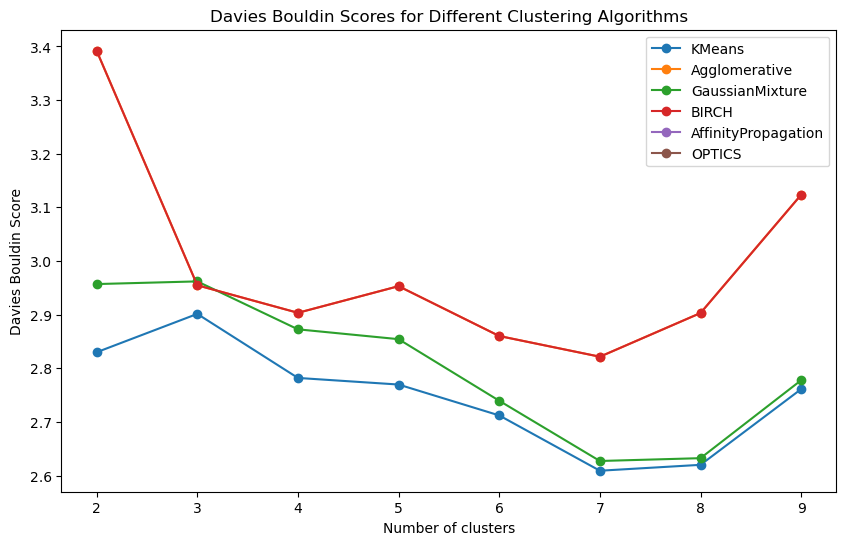

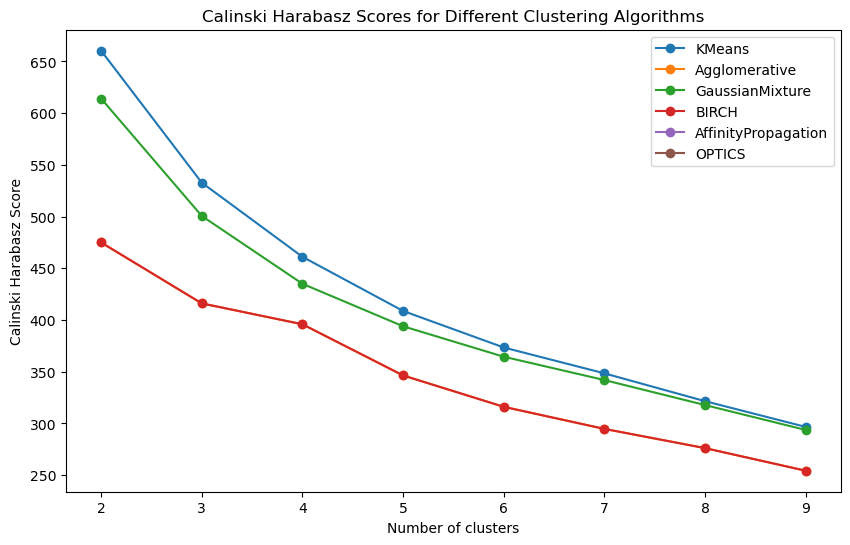

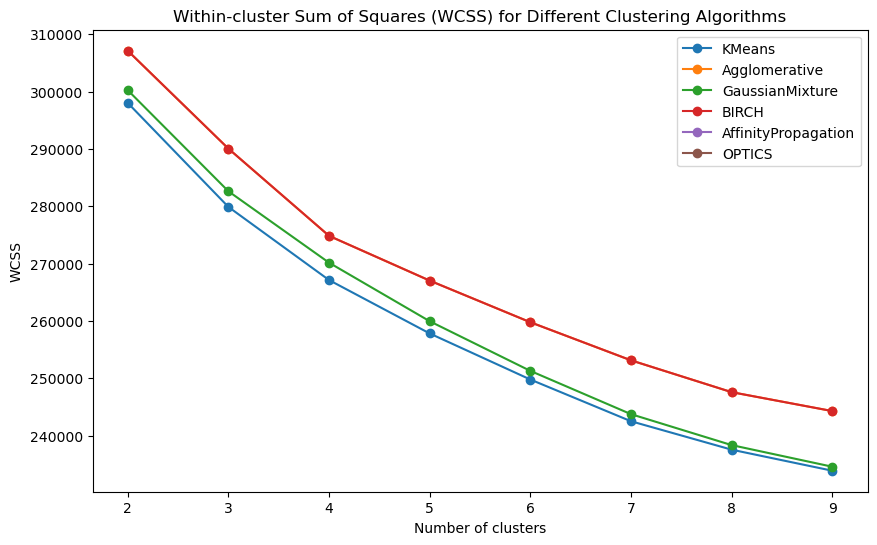

In [18]:
# without DBSCAN, MeanShift
clustering_results_filtered_2 = {
    model: results for model, results in clustering_results_filtered.items() if model not in ["DBSCAN", "MeanShift"]
}
plot_clustering_results(clustering_results_filtered_2)

# It appears that 
David-Bouldin Index (lower is better) seems to perfrom well in the open-cluster eval, given hints to the actual embedding cluster numbers (7).
    Evaluates the average similarity ra-
    tio of each cluster with the cluster
    that is most similar to it. Lower val-
    ues indicate more compact and well-
    separated clusters.

Siluette Score (higher is better) seems to perform ok for clusters > 2. It's inflated for n_clusters = 2, because the separation between the two clusters might appear significant due to the dichotomy, even if the underlying data structure is more complex. 


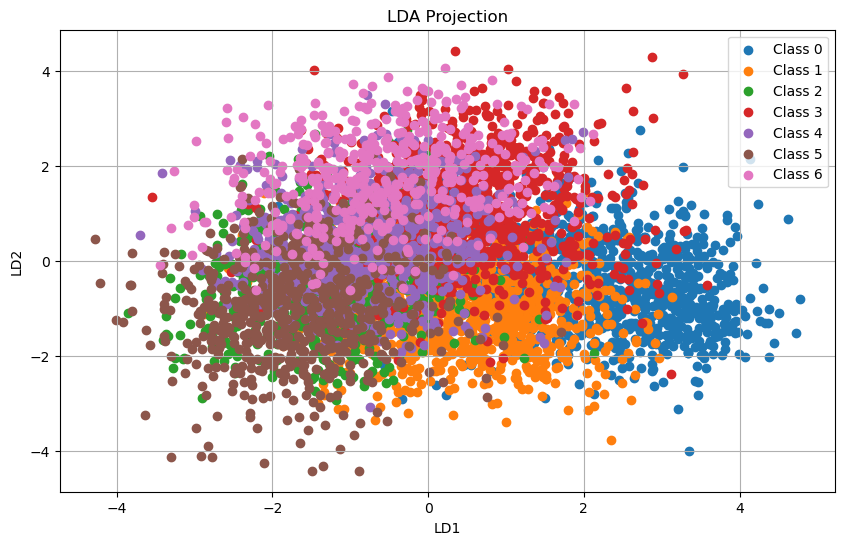

In [30]:
# Linear Discriminant Analysis (LDA) for dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Perform LDA
lda = LDA(n_components=2)
lda_transformed = lda.fit_transform(embeddings, labels.astype(int))

# Plot the results
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    plt.scatter(lda_transformed[labels == label, 0], lda_transformed[labels == label, 1], label=f"Class {label}")
plt.title("LDA Projection")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True)
plt.show()

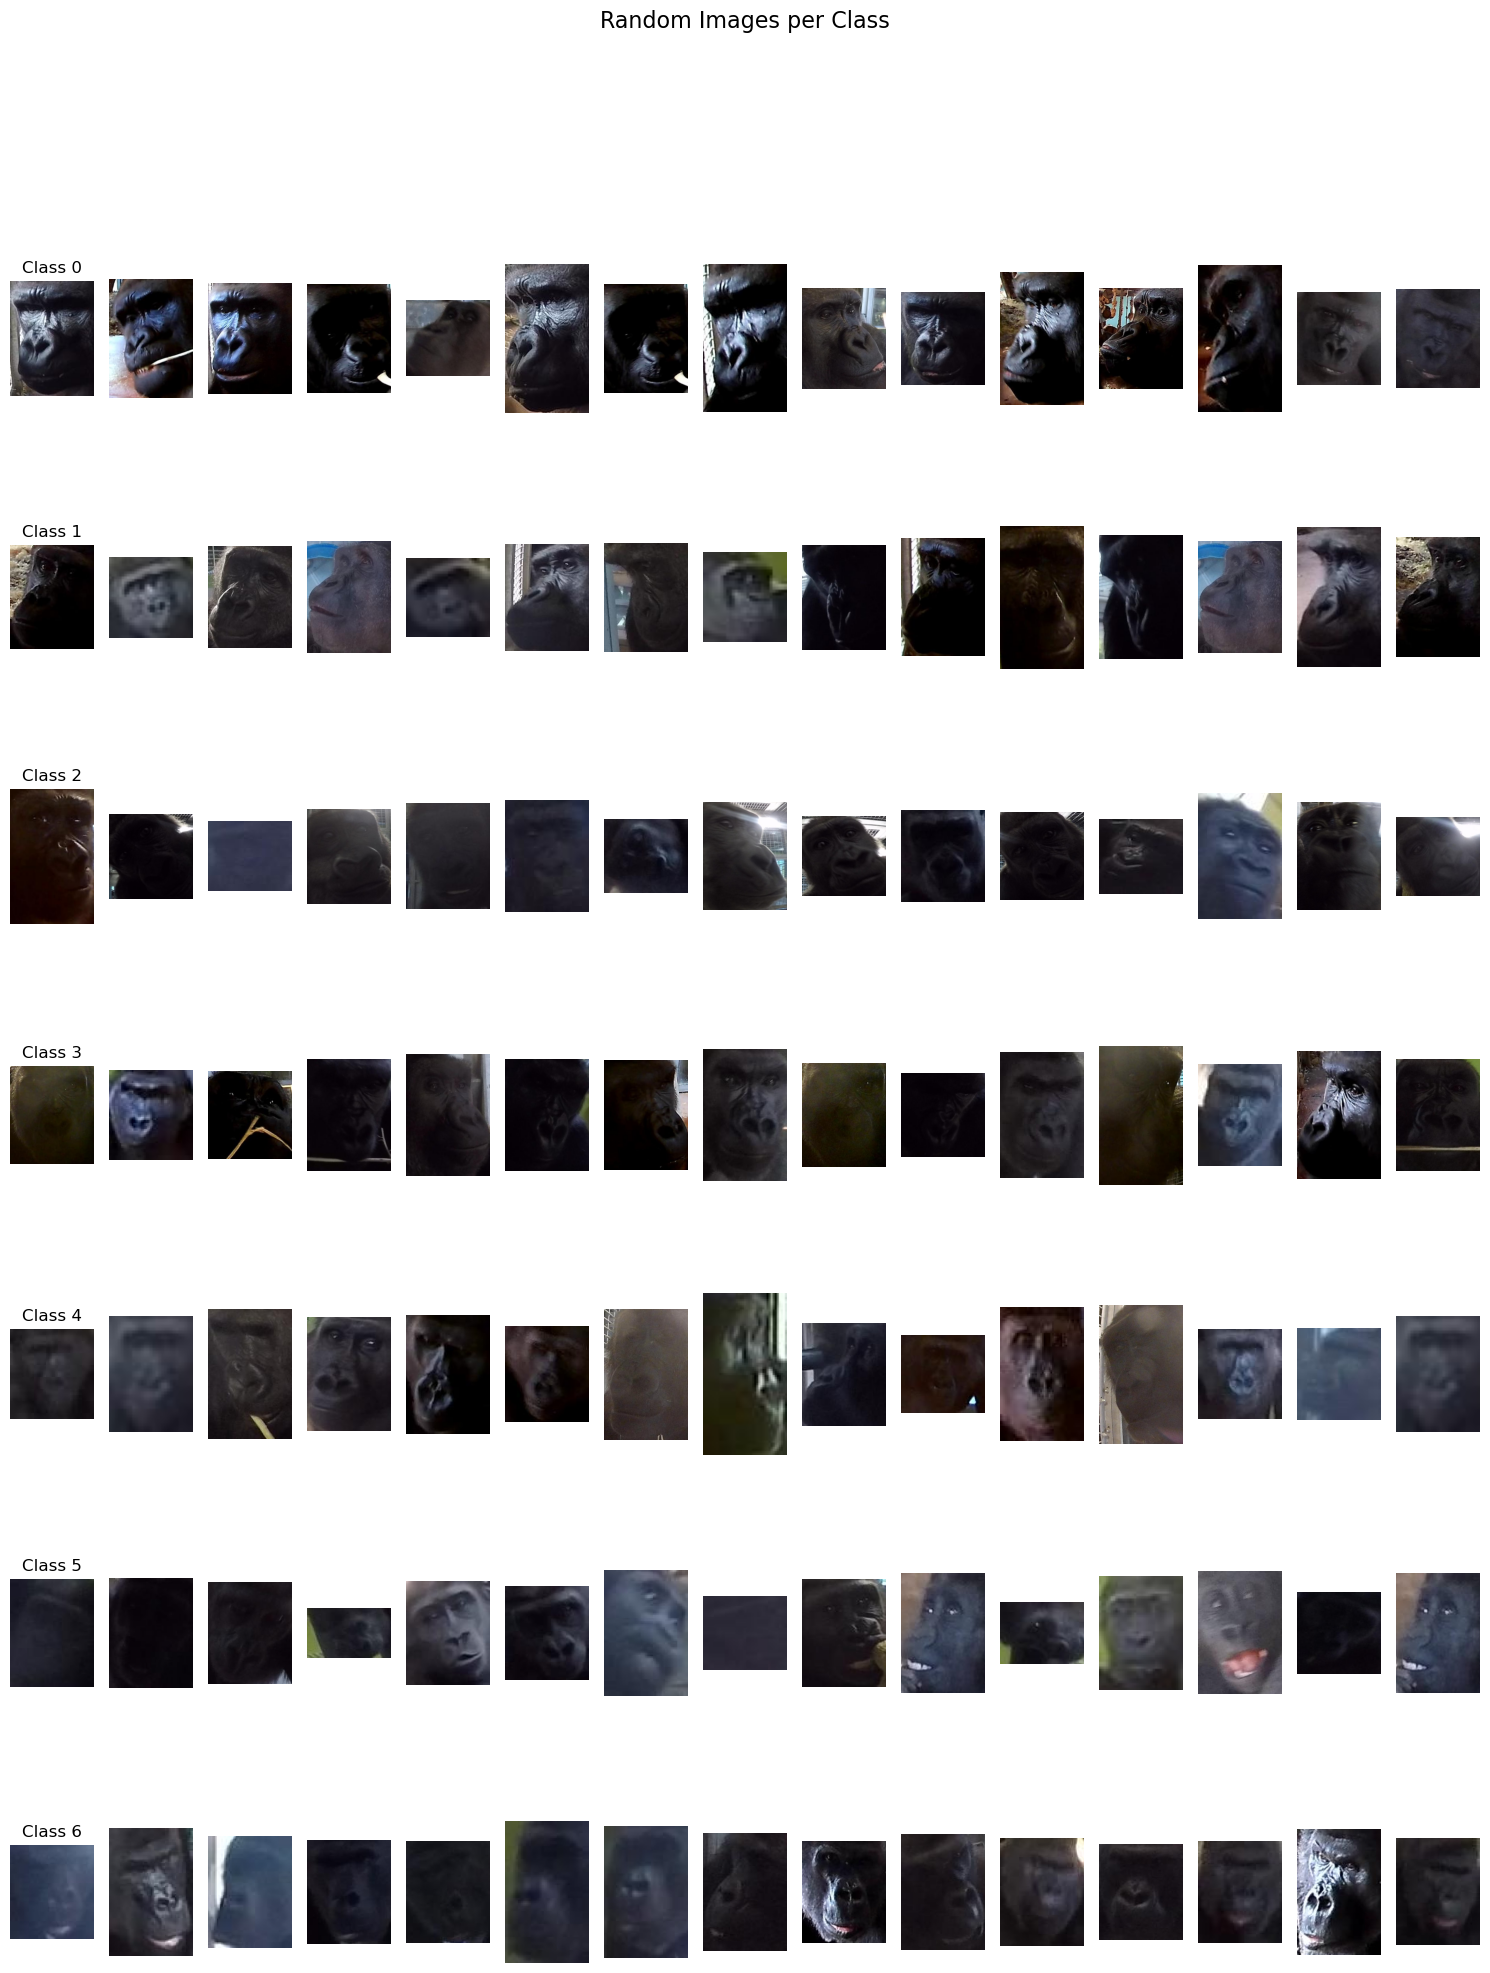

In [31]:
from PIL import Image


def visualize_classes(df, n_images=5):
    # Extract unique labels
    labels = df["label"].unique()

    # Plot setup
    fig, axes = plt.subplots(len(labels), n_images, figsize=(15, 3 * len(labels)))
    fig.suptitle("Random Images per Class", fontsize=16)

    # Display images
    for i, label in enumerate(labels):
        # Filter images by label
        label_df = df[df["label"] == label]

        # Randomly select n_images images
        selected_images = label_df.sample(n=n_images, replace=True)["id"].values

        for j, img_path in enumerate(selected_images):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(f"Class {label}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


visualize_classes(df, n_images=15)